In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [40]:
c = pd.read_csv('Customers.csv')  
p = pd.read_csv('Products.csv')   
t = pd.read_csv('Transactions.csv') 

In [41]:
m = pd.merge(t, c, on='CustomerID', how='inner')

In [42]:
m = pd.merge(m, p, on='ProductID', how='inner')

In [43]:
m.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [44]:
m=m.drop('Price_x',axis=1)

In [54]:
m.rename(columns = {"Price_y":"Price"},inplace=True)

In [56]:
m.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,CustomerName,Region,SignupDate,ProductName,Category,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [58]:
# Aggregating transaction data by CustomerID to get:
# - monetary_value: Total value spent by the customer
# - frequency: Number of transactions made by the customer
# - recency: Number of days since the last transaction
customer_data = m.groupby('CustomerID').agg(
    monetary_value=('TotalValue', 'sum'),
    frequency=('TransactionID', 'count'),
    recency=('TransactionDate', lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).days)
).reset_index()

In [60]:
customer_data.isnull().sum()

CustomerID        0
monetary_value    0
frequency         0
recency           0
dtype: int64

In [62]:
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['monetary_value', 'frequency', 'recency']])


In [64]:
inertia = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

C:\Users\shaky\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shaky\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shaky\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shaky\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

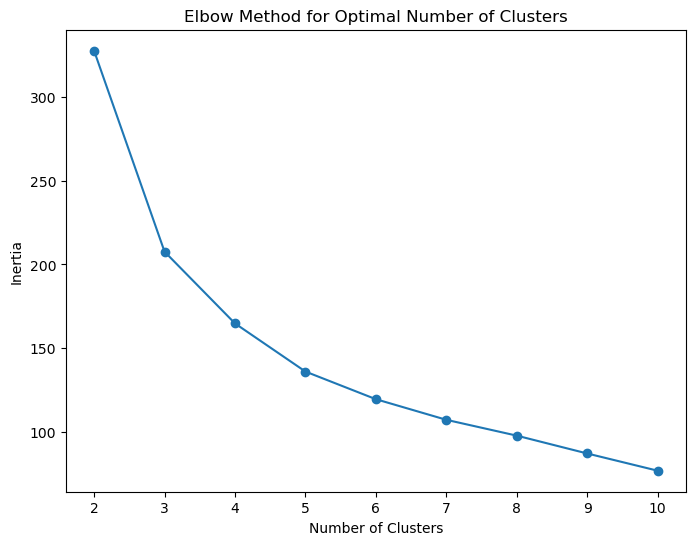

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [68]:
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(customer_data_scaled)

C:\Users\shaky\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shaky\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [70]:
db_index = davies_bouldin_score(customer_data_scaled, customer_data['cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.0363545131251188


In [72]:
sil_score = silhouette_score(customer_data_scaled, customer_data['cluster'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.30241610842019906


In [74]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_data_scaled)

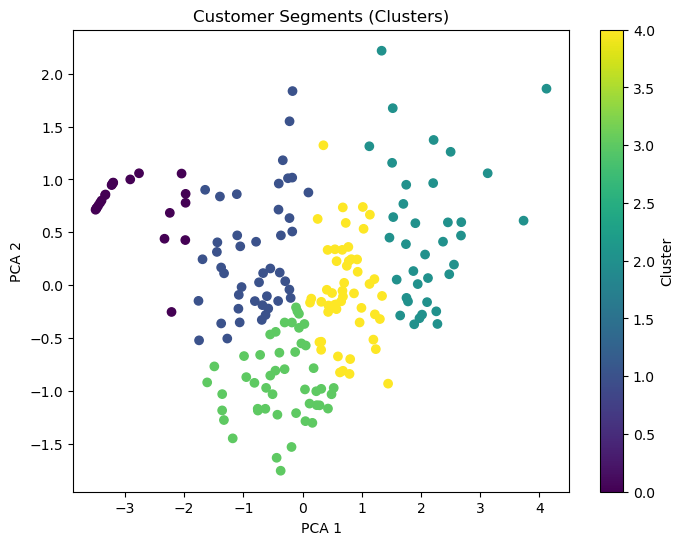

In [76]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=customer_data['cluster'], cmap='viridis')
plt.title('Customer Segments (Clusters)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


In [78]:
cluster_summary = customer_data.groupby('cluster').agg(
    average_monetary_value=('monetary_value', 'mean'),
    average_frequency=('frequency', 'mean'),
    average_recency=('recency', 'mean')
).reset_index()

In [80]:
print(cluster_summary)

   cluster  average_monetary_value  average_frequency  average_recency
0        0              948.143333           1.619048        27.142857
1        1             2949.194318           3.977273       166.318182
2        2             6141.713333           8.222222       285.388889
3        3             2281.924167           4.062500       277.729167
4        4             4193.719200           6.000000       263.440000
